## Get Data

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import time
import numpy as np
import pandas as pd
import itertools
import heapq

file_name = 'who.csv'
data = pd.read_csv(file_name)



columns_of_interest = np.array([
    'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles',
    'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria',
    'HIV/AIDS', 'GDP', 'Population', 'thinness1-19', 'thinness5-9',
    'Income composition of resources', 'Schooling'
])

data = data.dropna()
output = data['Life expectancy']
data = data[columns_of_interest]

## Normalize Data

In [2]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

## Visualize Data

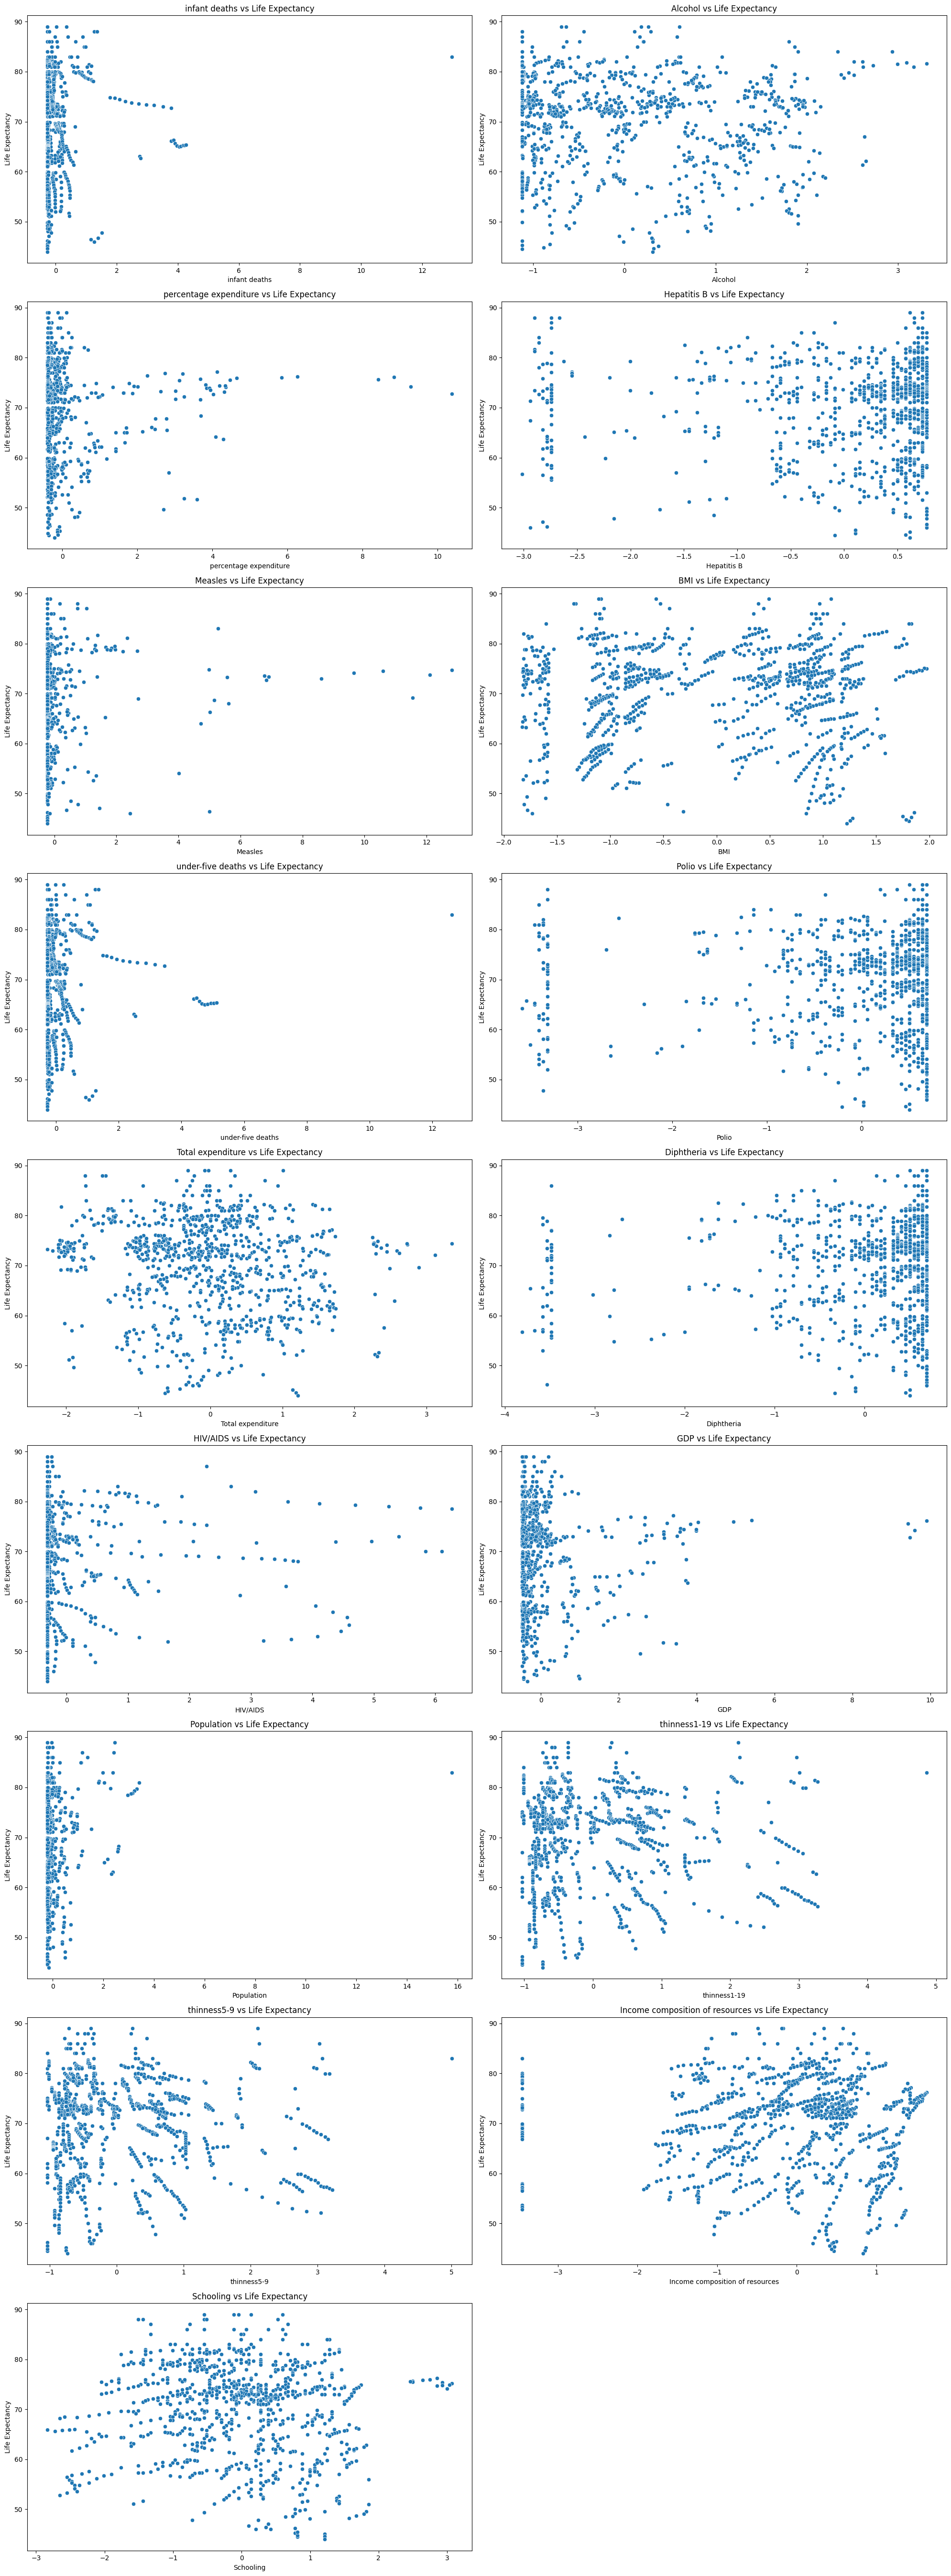

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of rows/columns for the subplots
n_columns = len(data.columns)
n_rows = n_columns // 2 + (n_columns % 2)

# Set the size of the overall figure
plt.figure(figsize=(20, 6 * n_rows))

for i, column in enumerate(data.columns):
    # Create a subplot for each column
    plt.subplot(n_rows, 2, i + 1)
    sns.scatterplot(x=data[column], y=output)
    plt.title(f'{column} vs Life Expectancy')
    plt.xlabel(column)
    plt.ylabel('Life Expectancy')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('prelim_data_vs.png', dpi=300, bbox_inches='tight')
plt.show()


## Regression + PCA

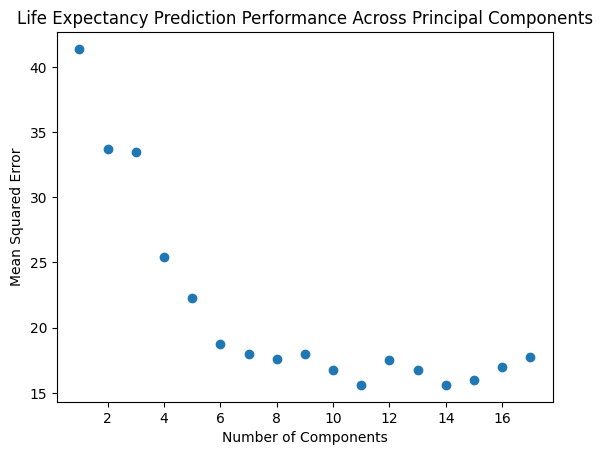

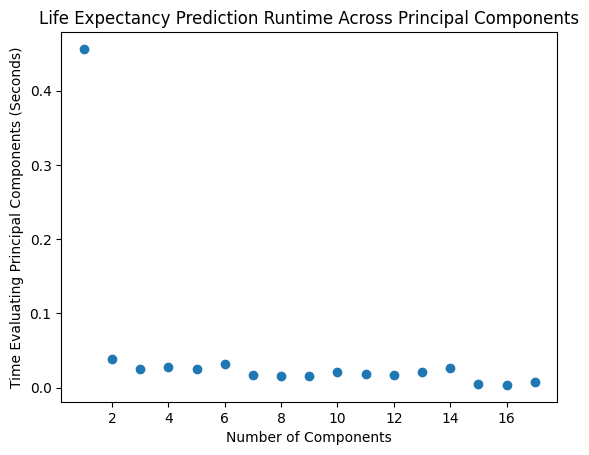

In [4]:
def regress_test(data, output):
  train_in, test_in, train_out, test_out = train_test_split(data, output, test_size=0.2)

  reg_BMI_GDP = LinearRegression().fit(train_in, train_out)
  predictions = reg_BMI_GDP.predict(test_in)
  return mean_squared_error(predictions, test_out)

test_components = np.arange(1, data.shape[1] + 1)
scores = []
times = []

for n_comp in test_components:
  pca_regress = PCA(n_components=n_comp)
  start_time = time.time()
  pca_regress_reduction = pca_regress.fit_transform(data)
  times.append(time.time() - start_time)
  scores.append(regress_test(pca_regress_reduction, output))

plt.scatter(test_components, scores)
plt.xlabel('Number of Components')
plt.ylabel('Mean Squared Error')
plt.title('Life Expectancy Prediction Performance Across Principal Components')
plt.show()

plt.scatter(test_components, times)
plt.xlabel('Number of Components')
plt.ylabel('Time Evaluating Principal Components (Seconds)')
plt.title('Life Expectancy Prediction Runtime Across Principal Components')
plt.show()

## Standard Regression

In [5]:
features = np.arange(data.shape[1])
combinations = list(itertools.combinations(features, 4))
h = []

for index, feature_group in enumerate(combinations):
  cur_score = regress_test(data[columns_of_interest[list(feature_group)]], output)
  heapq.heappush(h, (-cur_score, list(feature_group)))
  if len(h) > 10:
    heapq.heappop(h)

print('Top 10 Feature Combinations (MSE):')
for res in h:
  print(f'MSE: {-res[0]} Features: {columns_of_interest[list(res[1])]}')

Top 10 Feature Combinations (MSE):
MSE: 17.73694356337809 Features: ['under-five deaths' 'HIV/AIDS' 'GDP' 'Schooling']
MSE: 17.646776415706523 Features: ['BMI' 'HIV/AIDS' 'thinness1-19' 'Schooling']
MSE: 17.54510982630731 Features: ['Polio' 'Total expenditure' 'HIV/AIDS' 'Schooling']
MSE: 17.516666825695474 Features: ['HIV/AIDS' 'GDP' 'Population' 'Schooling']
MSE: 17.51993633130662 Features: ['HIV/AIDS' 'Population' 'Income composition of resources' 'Schooling']
MSE: 17.245545085034863 Features: ['percentage expenditure' 'HIV/AIDS' 'thinness5-9' 'Schooling']
MSE: 15.252876979140042 Features: ['percentage expenditure' 'HIV/AIDS' 'Income composition of resources'
 'Schooling']
MSE: 17.44945318840208 Features: ['HIV/AIDS' 'thinness5-9' 'Income composition of resources' 'Schooling']
MSE: 16.500371538386073 Features: ['under-five deaths' 'HIV/AIDS' 'Income composition of resources'
 'Schooling']
MSE: 16.580692527180243 Features: ['infant deaths' 'Diphtheria' 'HIV/AIDS' 'Income composition 

# Deep Learning

In [31]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

train_in, test_in, train_out, test_out = train_test_split(data, output, test_size=0.2)
train_in = np.array(train_in)
train_out = np.array(train_out)
test_in = np.array(test_in)
test_out = np.array(test_out)

train_inputs = torch.tensor(train_in, dtype=torch.float32)
train_outputs = torch.tensor(train_out, dtype=torch.float32)
test_inputs = torch.tensor(test_in, dtype=torch.float32)
test_outputs = torch.tensor(test_out, dtype=torch.float32)

train_dataset = TensorDataset(train_inputs, train_outputs)
test_dataset = TensorDataset(test_inputs, test_outputs)


input_size = len(train_in[0])

class NetA(nn.Module):
	def __init__(self):
		super(NetA, self).__init__()
		self.fc1 = nn.Linear(input_size, 10)
		self.fc2 = nn.Linear(10, 1)

	def forward(self, x):
		x = torch.relu(self.fc1(x))
		x = self.fc2(x)
		return x


class NetB(nn.Module):
	def __init__(self):
		super(NetB, self).__init__()
		self.fc1 = nn.Linear(input_size, 20)
		self.fc2 = nn.Linear(20, 10)
		self.fc3 = nn.Linear(10, 1)


	def forward(self, x):
		x = torch.sigmoid(self.fc1(x))
		x = torch.tanh(self.fc2(x))
		x = self.fc3(x)

		return x

class NetC(nn.Module):
	def __init__(self):
		super(NetC, self).__init__()
		self.fc1 = nn.Linear(input_size, 4)
		self.fc2 = nn.Linear(4, 3)
		self.fc3 = nn.Linear(3, 2)
		self.fc4 = nn.Linear(2, 1)

	def forward(self, x):
		x = torch.relu(self.fc1(x))
		x = torch.relu(self.fc2(x))
		x = torch.relu(self.fc3(x))
		x = self.fc4(x)
		return x

def train_model(model, criterion, optimizer, num_epochs=50):
	training_losses = np.array([])
	testing_losses = np.array([])

	for epoch in range(num_epochs):
		model.train()
		optimizer.zero_grad()
		output = model(train_inputs)
		loss = criterion(output, train_outputs)
		loss.backward()
		optimizer.step()
		training_losses = np.append(training_losses, loss.item())

		model.eval()
		with torch.no_grad():
			test_output = model(test_inputs)
			test_loss = criterion(test_output, test_outputs)
			testing_losses = np.append(testing_losses, test_loss.item())

	return training_losses / len(train_out), testing_losses/len(test_out)


def plot_results(training_losses, testing_losses, title="Model Loss"):
	plt.figure(figsize=(10, 5))
	plt.plot(training_losses, label='Training Loss')
	plt.plot(testing_losses, label='Testing Loss')
	plt.title(title)
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.legend()
	plt.grid(True)
	plt.show()

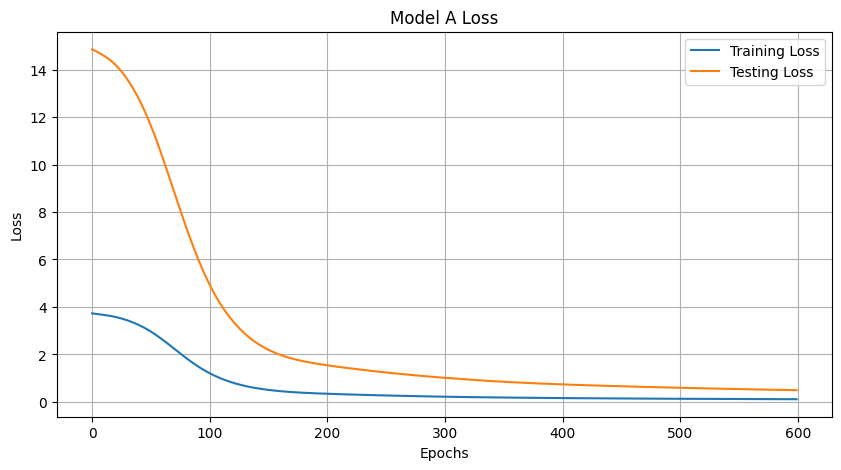

Model A MSE  0.4929348107540246


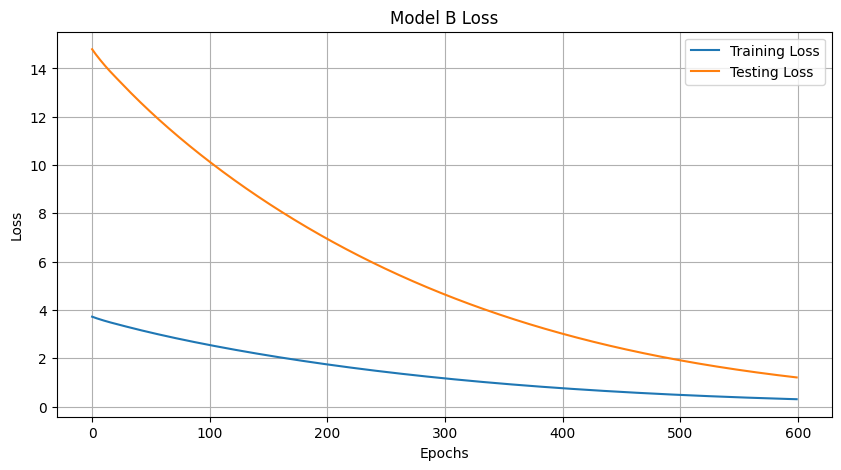

Model B MSE  1.2081331195253315


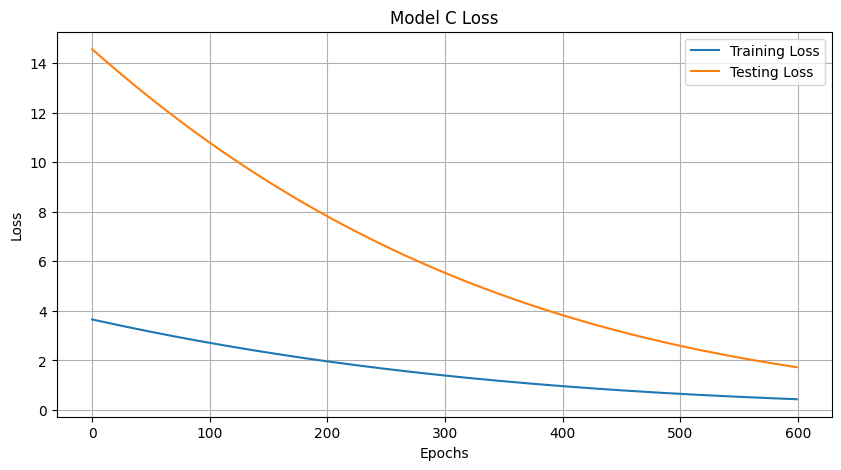

Model C MSE  1.7303660999644885


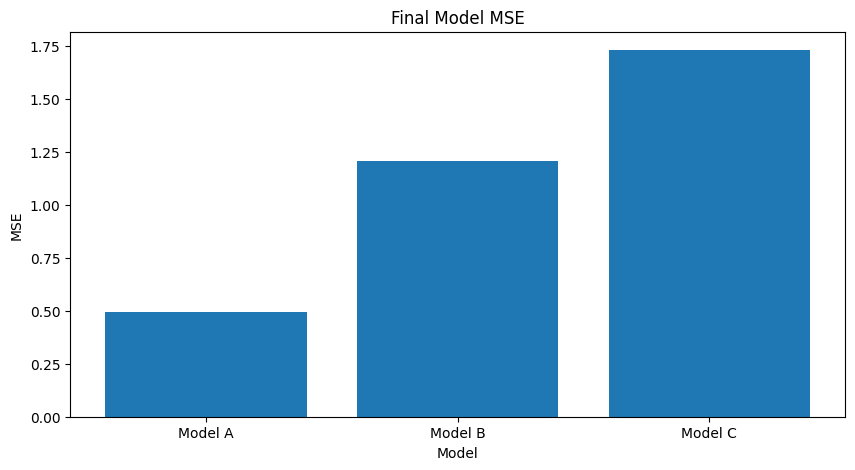

In [32]:
criterion = nn.MSELoss()

modelA = NetA()
optimizer = torch.optim.Adam(modelA.parameters(), lr=0.01)
training_losses, testing_losses_A = train_model(modelA, criterion, optimizer, num_epochs=600)
plot_results(training_losses, testing_losses_A, title="Model A Loss")

print("Model A MSE ", testing_losses_A[-1])

modelB = NetB()
optimizer = torch.optim.Adam(modelB.parameters(), lr=0.01)
training_losses, testing_losses_B = train_model(modelB, criterion, optimizer, num_epochs=600)
plot_results(training_losses, testing_losses_B, title="Model B Loss")
print("Model B MSE ", testing_losses_B[-1])


modelC = NetC()
optimizer = torch.optim.Adam(modelC.parameters(), lr=0.1)
training_losses, testing_losses_C = train_model(modelC, criterion, optimizer, num_epochs=600)
plot_results(training_losses, testing_losses_C, title="Model C Loss")
print("Model C MSE ", testing_losses_C[-1])

# create a bar graph for testing losses
plt.figure(figsize=(10, 5))
plt.bar(['Model A', 'Model B', 'Model C'], [testing_losses_A[-1], testing_losses_B[-1], testing_losses_C[-1]])
plt.title('Final Model MSE')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()
